In [64]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import random

# Определим будущие параметры
___
 - `board_size` — размер доски (n x n)
 - `learning_rate` — 
 - `discount_factor` — 
 - `random_move_probability` — вероятность случайного хода
 - `num_episodes` — количество эпизодов для обучения

In [65]:
# Настройки
board_size = 3
learning_rate = 0.1
discount_factor = 0.9
random_move_probability = 0.2  # вероятность случайного хода (exploration)
num_episodes = 1000  # количество эпизодов для обучения

# Функция создания поля
Создаем поле по входным параметрам и заполняем его нулями
___
**параметры:** 
 - `n` — размер поля (n x n)
___
*возвращает двумерный массив нулей размером n x n*

In [66]:
# Создаем игровое поле
def create_board(n):
    return np.zeros((n, n), dtype=int)

# Функция проверки на выигрыш
Определяет, достиг ли один из игроков победы, или зафиксирована ничья
___
**параметры:**  
- `board` — текущее состояние игрового поля, двумерный массив
___
*возвращает:*  
- `1` — если победил первый игрок (крестики)  
- `-1` — если победил второй игрок (нолики)  
- `0` — если игра завершилась ничьей  
- `None` — если игра продолжается

In [67]:

# Проверка на выигрыш
def check_winner(board):
    for player in [1, -1]: # 1 - крестики, -1 - нолики
        if any(np.all(line == player) for line in np.vstack((board, board.T, np.diag(board), np.diag(np.fliplr(board))))):
            return player
    if not np.any(board == 0):
        return 0  # ничья
    return None  # игра продолжается

# Функция выбора действия с использованием ε-жадного метода
Выбирает действие агента: случайное (для исследования) или с наибольшим Q-значением (для использования опыта)
___
**параметры:**  
- `state` — текущее состояние поля в виде кортежа  
- `q_table` — Q-таблица, в которой хранится ценность каждого действия для каждого состояния  
___
*возвращает индекс выбранного действия (от 0 до 8 для поля 3x3)*

In [68]:

# Функция выбора действия с использованием ε-жадного метода
def choose_action(state, q_table):
    if random.uniform(0, 1) < random_move_probability:
        return random.choice([i for i in range(9) if state[i] == 0])
    else:
        q_values = [q_table[(tuple(state), a)] for a in range(9)]
        return int(np.argmax(q_values))


# Функция обновления Q-значений
Обновляет Q-значение для состояния и действия с использованием временного разрыва (TD)  
___
**параметры:**  
- `q_table` — Q-таблица для хранения ценностей действий  
- `state` — текущее состояние поля (кортеж)  
- `action` — выбранное действие (целое число, индекс ячейки)  
- `reward` — награда за текущее действие  
- `next_state` — следующее состояние поля после выполнения действия  
___
*ничего не возвращает, обновляет Q-значение для данного состояния и действия в q_table*

In [69]:

# Обновление Q-значений
def update_q_value(q_table, state, action, reward, next_state):
    best_next_action = int(np.argmax([q_table[(tuple(next_state), a)] for a in range(9)]))
    td_target = reward + discount_factor * q_table[(tuple(next_state), best_next_action)]
    td_delta = td_target - q_table[(tuple(state), action)]
    q_table[(tuple(state), action)] += learning_rate * td_delta



# Функция преобразования игрового поля в состояние
Преобразует двумерный массив игрового поля в одномерный кортеж состояния  
___
**параметры:**  
- `board` — текущее состояние игрового поля, двумерный массив  
___
*возвращает текущее состояние в виде одномерного кортежа*

In [70]:
# Преобразование игрового поля в строку состояния
def get_state(board):
    return tuple(board.flatten())


# Цикл обучения агента для игры в "крестики-нолики" с использованием Q-обучения
Агент многократно играет партии с целью улучшения стратегии.

___
- `q_table = defaultdict(float)` — инициализация Q-таблицы в виде словаря с автоматическим присвоением значения `0.0` для каждого нового состояния-действия. Q-таблица хранит ценности (Q-значения) для каждого действия в каждом состоянии.
- `rewards = []` — пустой список для накопления наград по каждой партии.


In [76]:
q_table = defaultdict(float) 
rewards = [] 

# цикл обучения
for episode in range(num_episodes): # цикл обучения, в котором агент играет num_episodes партий
    board = create_board(board_size) # создание пустого поля размером `board_size x board_size`
    state = get_state(board) # получение текущего состояния поля в виде кортежа
    total_reward = 0
    while True:
        # ход агента
        action = choose_action(state, q_table) # выбор действия на основе ε-жадного метода (случайный или наилучший ход).
        x, y = divmod(action, board_size) # преобразование линейного индекса действия в координаты x и y
        
        if board[x, y] != 0: # если ячейка занята, ход игнорируется (начинается новый цикл)
            continue  # неправильный ход, игнорируем
        
        board[x, y] = 1  # агент ставит крестик
        winner = check_winner(board) # проверка на победу
        
        if winner is not None: # игра закончилась
            reward = 1 if winner == 1 else 0.5 if winner == 0 else 0 # награды агента в зависимости от статуса победы
            update_q_value(q_table, state, action, reward, state) # обновление Q-значения для текущего состояния и действия
            total_reward += reward # добавление награды за текущую партию
            break
        
        # ход противника (случайный)
        empty_cells = list(zip(*np.where(board == 0))) # определение списка пустых ячеек
        if empty_cells: # если есть пустые ячейки
            x, y = random.choice(empty_cells) # случайный выбор пустой ячейки для хода противника
            board[x, y] = -1 # случайно ставим нолик
            winner = check_winner(board) # проверка на победу
            if winner is not None:
                reward = 0 # если агент проиграл
                update_q_value(q_table, state, action, reward, state) # обновление Q-значения
                break # выход из цикла игры
        
        next_state = get_state(board) # получение нового состояния поля
        update_q_value(q_table, state, action, 0, next_state) # обновление Q-значения для текущего действия без награды
        state = next_state # переход к следующему состоянию
    rewards.append(total_reward) # добавление итоговой награды за партию в список


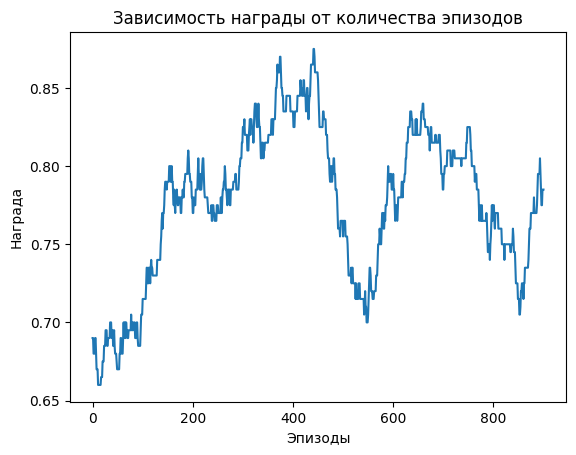

In [90]:
# Построение графика зависимости награды от количества эпизодов
plt.plot(np.convolve(rewards, np.ones(int(num_episodes / 10))/int(num_episodes / 10), mode='valid'))
plt.xlabel('Эпизоды')
plt.ylabel('Награда')
plt.title('Зависимость награды от количества эпизодов')
plt.show()